In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import json
import scripts
import scripts1
import scripts2
import scripts3
import dynamics as dyn

import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc


%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun
PC_AU = 206265 ##pc to AU

testpath = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rundir_test14/8e5rv1rg8z0.002_tc_poly/'
#testpath = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rundir_test16/1.6e6rv0.5rg8z0.002_tc_poly/'

##Extracting the data from test 13 (the most recent test)
prop_init, prop_finl, prop_des = tc.find_tc_properties(testpath)
print(len(prop_init['id0']), len(prop_finl['id0']), len(prop_des['id0']))


##Separate giant collisions and tidal captureindex_coll_bin = []
index_tc_bin = []
index_coll_bin = []
index_tc_des = []
index_coll_des = []

types_bin = prop_init['type']
for i in range(len(types_bin)):
    if types_bin[i] == 'SS_COLL_Giant': index_coll_bin.append(i)
    if types_bin[i] == 'SS_COLL_TC_P': index_tc_bin.append(i)
        
types_des = prop_des['type']
for i in range(len(types_des)):
    if types_des[i] == 'SS_COLL_Giant': index_coll_des.append(i)
    if types_des[i] == 'SS_COLL_TC_P': index_tc_des.append(i)
    
#index_coll = index_coll_bin+index_coll_des
#index_tc = index_tc_bin+index_tc_des

print(len(index_coll_bin), len(index_tc_bin))
print(len(index_coll_des), len(index_tc_des))


##Extract data from the collision file
collfile = testpath+'initial.collision.log'
colldata = scripts1.readcollfile(collfile)
#print(colldata)

all_sscoll = {'time':[], 'idm':[], 'id0':[], 'id1':[], 'mm':[], 'm0':[], 'm1':[], 'km':[], 'k0':[], 'k1':[], 
             'r0':[], 'r1':[], 'rclu':[], 'vinf':[], 'rperi':[], 'coll_mult':[]}
for k in range(len(colldata)):
    line = colldata[k].split()
    #print(line)
    if line[1]=='single-single':
        all_sscoll['time'].append(float(line[0]))
        all_sscoll['idm'].append(int(line[3])); all_sscoll['id0'].append(int(line[5])); all_sscoll['id1'].append(int(line[7]))
        all_sscoll['mm'].append(float(line[4])); all_sscoll['m0'].append(float(line[6])); all_sscoll['m1'].append(float(line[8]))
        all_sscoll['rclu'].append(float(line[9]))
        all_sscoll['km'].append(int(line[10])); all_sscoll['k0'].append(int(line[11])); all_sscoll['k1'].append(int(line[12]))
        all_sscoll['vinf'].append(float(line[14]))
        all_sscoll['r0'].append(float(line[15])); all_sscoll['r1'].append(float(line[16]))
        all_sscoll['rperi'].append(float(line[17])); all_sscoll['coll_mult'].append(float(line[18])) 
        

##Separate ss collisions into different categories
coll_des_id0 = np.take(prop_des['id0'], index_coll_des)
coll_des_id1 = np.take(prop_des['id1'], index_coll_des)

tc_des_id0 = np.take(prop_des['id0'], index_tc_des)
tc_des_id1 = np.take(prop_des['id1'], index_tc_des)

index_sticky = []; index_tccoll = []
index_gmerge = []; index_tde = []
index_bhns_tde = []
for k in range(len(all_sscoll['k0'])):
    if all_sscoll['id0'][k] in coll_des_id0:
        index_gmerge.append(k)
        index_tccoll.append(k)
    elif all_sscoll['id0'][k] in tc_des_id0:
        index_tde.append(k)
        index_tccoll.append(k)
    elif all_sscoll['coll_mult'][k]==1.:
        index_sticky.append(k)
        #if all_sscoll['k0'][k]>=13 or all_sscoll['k1'][k]>=13:
        #    print(all_sscoll['id0'][k], all_sscoll['id1'][k])
    #elif all_sscoll['k0'][k]>=13 or all_sscoll['k1'][k]>=13:
    #    index_tde.append(k)
    #elif (2<=all_sscoll['k0'][k]<=9 and all_sscoll['k0'][k]!=7) or (2<=all_sscoll['k1'][k]<=9 and all_sscoll['k1'][k]!=7):
    #    index_gmerge.append(k)
    #    print(all_sscoll['id0'][k], all_sscoll['id1'][k], all_sscoll['k0'][k], all_sscoll['k1'][k], all_sscoll['m0'][k],
    #         all_sscoll['m1'][k])
    
    else:
        index_bhns_tde.append(k)
                 
print(len(index_sticky), len(index_tccoll))
print(len(index_gmerge), len(index_tde))
print(len(index_bhns_tde))

##Check what are the others
other_id0 = np.take(all_sscoll['id0'], index_bhns_tde)
other_k0 = np.take(all_sscoll['k0'], index_bhns_tde)
other_k1 = np.take(all_sscoll['k1'], index_bhns_tde)

print(other_k0, other_k1)

2.1.2


ValueError: could not convert string to float: 'merged'

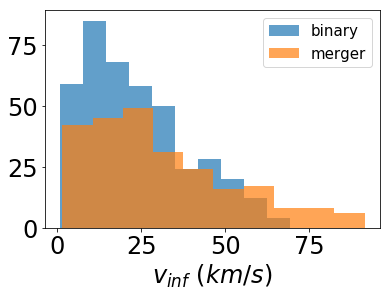

In [3]:
##plot the distribution of v_inf
plt.figure()
plt.hist(prop_init['vinf'], alpha=0.7, label = 'binary')
plt.hist(prop_des['vinf'], alpha=0.7, label = 'merger')
plt.xlabel(r'$v_{inf}\ (km/s)$')
plt.legend(loc='best', fontsize=15)

[ 1  0  1  0  1  0  0  1  0 14  1  0  0  0 14  0  0  0  0  0  1 14 14 14
  0 14  1 14  0  0  0  0 14  0  1  0 13  0 14  0  0 14  1  0 11  0  1  0
  0  0 14  0  1  0 14  0  1  0  0 14  1  0  1 11 14  0  0  0  0  0  0  0
  1 14  0  0  1 11  1  0  0  0 11 14  0  0  0 14  0  1  0 11  0  0  0  1
 11  0  0 14  0 14  0  1  0  0  0  0 14  1  0  0 11  1  0 11  0 11  0 11
 14  0  0  1  0  0  0  0 11  0 11 11  0  1 14  0  0  0 11 11  0  1  0 12
  1  0 11 12 11 11  0  1 11  0  0  0 11  0  0  0  0  1 11  0  0 11  0 12
  0] [ 0  1  0  1  0 14  0  0 14  1  0 14  0  1  0 14 14 14  1  0  0  0  0  0
  0  1  0  1 14  0  0 12  0  1 14 14  0  0  0 14  0  0 14  0  0 14  0  0
 11  0  0  0 14 14  1  1  0 14  0  1  1  0  0  1  0  1  0  1  1  0  0  1
  0  0  0  0  0  0 11 11  0 14  0  0  0  0 11  0  0 14  0  1 14 11 11 11
  1 14  0  0  0  0 14 14 11  1 11  0  0  0  0  0  0 14  0  1 11  0 14  0
  0  0 14  0 11  1 11 11  0 11  1  0  0  1  1  0 12 14  0  1  1  0  0  0
  1 14  0  1  0  0  0 11  0  0  0  0  0  1  0 

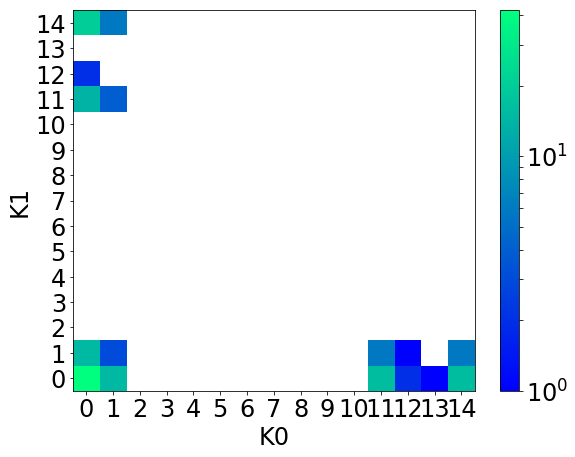

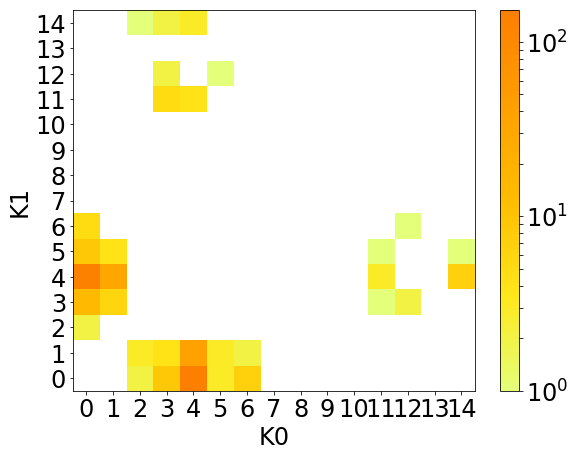

In [5]:
##plot the types of stars for tidal capture
tc_k0 = np.take(prop_init['k0'], index_tc_bin)
tc_k1 = np.take(prop_init['k1'], index_tc_bin)
print(tc_k0, tc_k1)

K0=[x - 0.5 for x in tc_k0]
K1=[Y - 0.5 for Y in tc_k1]
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='winter')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()


##plot the types of stars for giant-giant collisions
coll_k0_bin = np.take(prop_init['k0'], index_coll_bin)
coll_k1_bin = np.take(prop_init['k1'], index_coll_bin)
coll_k0_des = np.take(prop_des['k0'], index_coll_des)
coll_k1_des = np.take(prop_des['k1'], index_coll_des)
coll_k0 = np.concatenate((coll_k0_bin,coll_k0_des))
coll_k1 = np.concatenate((coll_k1_bin,coll_k1_des))
print(coll_k0, coll_k1)

K0=[x - 0.5 for x in coll_k0]
K1=[Y - 0.5 for Y in coll_k1]
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='Wistia')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()

In [7]:
##Compare final and initial star types of tidal capture binaries
tc_k0_init = np.take(prop_init['k0'], index_tc_bin)
tc_k1_init = np.take(prop_init['k1'], index_tc_bin)
tc_k0_finl = np.take(prop_finl['k0'], index_tc_bin)
tc_k1_finl = np.take(prop_finl['k1'], index_tc_bin)

k0_diff = [x - y for x, y in zip(tc_k0_finl, tc_k0_init)]
k1_diff = [x - y for x, y in zip(tc_k1_finl, tc_k1_init)]
print(np.nonzero(k0_diff), np.nonzero(k1_diff))

##Check final giant-giant collisions star types
coll_k0_init = np.take(prop_init['k0'], index_coll_bin)
coll_k1_init = np.take(prop_init['k1'], index_coll_bin)
coll_k0_finl = np.take(prop_finl['k0'], index_coll_bin)
coll_k1_finl = np.take(prop_finl['k1'], index_coll_bin)
coll_id0 = np.take(prop_init['id0'], index_coll_bin)
coll_id1 = np.take(prop_init['id1'], index_coll_bin)

n_not7 = 0
for i in range(len(coll_k0_init)):
    if 2<=coll_k0_init[i]<=9 and coll_k0_init[i]!=7:
        if coll_k0_finl[i]!=7: 
            print(coll_id0[i], coll_k0_init[i], coll_k0_finl[i])
            n_not7+=1
    if 2<=coll_k1_init[i]<=9 and coll_k1_init[i]!=7:
        if coll_k1_finl[i]!=7: 
            print(coll_id1[i], coll_k1_init[i], coll_k1_finl[i])
            n_not7+=1

print(n_not7)
##Does this look right?
##How exactly does stripping envelope work?

(array([], dtype=int64),) (array([], dtype=int64),)
628295 5 13
469564 5 8
299979 5 8
256572 5 8
301337 6 13
193005 5 8
182262 6 12
332215 6 12
792441 5 8
397128 5 8
408768 6 12
228422 6 12
367215 6 12
435065 5 9
174164 6 11
286567 6 11
49023 6 11
240421 6 11
739029 5 8
413637 6 11
456658 6 11
622398 2 10
595924 3 10
172473 5 8
760140 3 10
707141 5 8
607156 5 8
600671 3 10
681721 3 10
350152 3 10
148836 3 10
480189 3 10
427696 3 10
372832 3 10
669098 3 10
663396 3 10
705318 3 10
311643 5 8
381097 3 10
421525 5 11
176386 5 11
524885 3 10
357635 3 10
198627 3 10
688755 3 10
302139 3 10
46


Text(0,0.5,'$a/r_{peri}$')

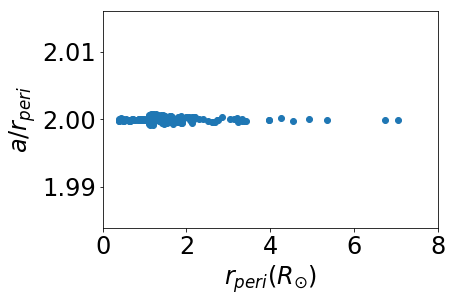

In [10]:
##check rperi and final sma of tidal capture binaries
tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
tc_sma = np.take(prop_finl['sma'], index_tc_bin)
tc_ecc = np.take(prop_finl['ecc'], index_tc_bin)

ratio = np.array(tc_sma)*AU_Rsun/np.array(tc_rperi)

plt.figure()
plt.scatter(tc_rperi, ratio)
#plt.scatter(tc_rperi, tc_ecc)
plt.xlim(0, 8)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$a/r_{peri}$')

(0, 8)

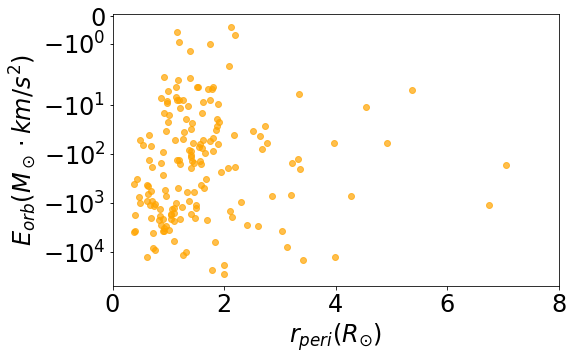

In [12]:
##check energy of tidal capture binaries
##Data from the fitting formulae
def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        printf("unknown polytropic index")
             
        

def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))
    

tc_m0 = np.take(prop_init['m0'], index_tc_bin)
tc_m1 = np.take(prop_init['m1'], index_tc_bin)
tc_r0 = np.take(prop_init['r0'], index_tc_bin)
tc_r1 = np.take(prop_init['r1'], index_tc_bin)
tc_k0 = np.take(prop_init['k0'], index_tc_bin)
tc_k1 = np.take(prop_init['k1'], index_tc_bin)
tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
tc_vinf = np.take(prop_init['vinf'], index_tc_bin)

E_osc = []
for i in range(len(tc_m0)):
    m_reduce = tc_m0[i]*tc_m1[i]/(tc_m0[i]+tc_m1[i])
    E_kin = 0.5*m_reduce*tc_vinf[i]**2
    
    if tc_k0[i]==1: n0 = 3.0
    elif tc_k0[i]==0: n0 = 1.5
    else: n0 = -100
    
    if tc_k1[i]==1: n1 = 3.0
    elif tc_k1[i]==0: n1 = 1.5
    else: n1 = -100
    
    if n0!=-100 and n1!=-100:
        E0_osc = E_oscillate(tc_rperi[i], tc_m0[i], tc_r0[i], n0, tc_m1[i])
        E1_osc = E_oscillate(tc_rperi[i], tc_m1[i], tc_r1[i], n1, tc_m0[i])
        
        E_osc.append(E_kin - E0_osc - E1_osc)
        
    elif n1==-100:
        E0_osc = E_oscillate(tc_rperi[i], tc_m0[i], tc_r0[i], n0, tc_m1[i])
        E_osc.append(E_kin - E0_osc)
    
    elif n0==-100:
        E1_osc = E_oscillate(tc_rperi[i], tc_m1[i], tc_r1[i], n1, tc_m0[i])
        E_osc.append(E_kin - E1_osc)
    else:
        print('Oops, something is wrong')
    
    
plt.figure(figsize = (8, 5))
plt.scatter(tc_rperi, E_osc, color = 'orange', alpha=0.7)
plt.yscale('symlog')
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$E_{orb}(M_\odot \cdot km/s^2)$')
plt.xlim(0, 8)

Text(0,0.5,'$ratios$')

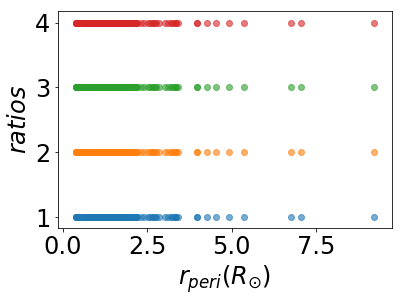

In [13]:
##Compare initial and final masses and radii of tidal capture binaries
tc_m0_init = np.take(prop_init['m0'], index_tc_bin)
tc_m1_init = np.take(prop_init['m1'], index_tc_bin)
tc_r0_init = np.take(prop_init['r0'], index_tc_bin)
tc_r1_init = np.take(prop_init['r1'], index_tc_bin)

tc_m0_finl = np.take(prop_finl['m0'], index_tc_bin)
tc_m1_finl = np.take(prop_finl['m1'], index_tc_bin)
tc_r0_finl = np.take(prop_finl['r0'], index_tc_bin)
tc_r1_finl = np.take(prop_finl['r1'], index_tc_bin)

tc_rperi = np.take(prop_init['rperi'], index_tc_bin)

ratio_m0 = tc_m0_finl/tc_m0_init
ratio_m1 = tc_m1_finl/tc_m1_init
ratio_r0 = tc_r0_finl/tc_r0_init
ratio_r1 = tc_r1_finl/tc_r1_init

plt.figure()
plt.scatter(tc_rperi, ratio_m0, alpha = 0.6)
plt.scatter(tc_rperi, ratio_m1+1, alpha = 0.6)
plt.scatter(tc_rperi, ratio_r0+2, alpha = 0.6)
plt.scatter(tc_rperi, ratio_r1+3, alpha = 0.6)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$ratios$')

In [14]:
##Check if the tidal capture binaries are mass transferring
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl
    

tc_m0 = np.take(prop_finl['m0'], index_tc_bin)
tc_m1 = np.take(prop_finl['m1'], index_tc_bin)
tc_r0 = np.take(prop_finl['r0'], index_tc_bin)
tc_r1 = np.take(prop_finl['r1'], index_tc_bin)
tc_sma = np.take(prop_finl['sma'], index_tc_bin)

for i in range(len(tc_m0)):
    rl0 = rochradius(tc_m0[i], tc_m1[i], tc_sma[i])
    rl1 = rochradius(tc_m1[i], tc_m0[i], tc_sma[i])
    if rl0<=tc_r0[i] or rl1<=tc_r1[i]:
        print('Oops, something is wrong')

21


Text(0.5,0,'$\\eta$')

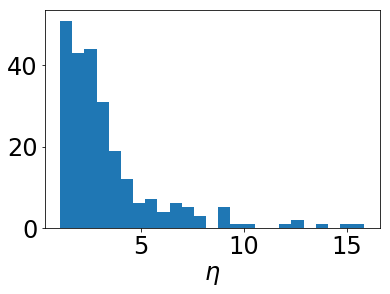

In [16]:
##Check eta for tidal capture process
def Eta(Mosc, Rosc, Mpert, rperi):
     return math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    
tc_m0 = np.take(prop_init['m0'], index_tc_bin)
tc_m1 = np.take(prop_init['m1'], index_tc_bin)
tc_r0 = np.take(prop_init['r0'], index_tc_bin)
tc_r1 = np.take(prop_init['r1'], index_tc_bin)
tc_k0 = np.take(prop_init['k0'], index_tc_bin)
tc_k1 = np.take(prop_init['k1'], index_tc_bin)
tc_rperi = np.take(prop_init['rperi'], index_tc_bin)

all_eta = []
n_eta = 0
for i in range(len(tc_k0)):
    if tc_k0[i]<=1:
        all_eta.append(Eta(tc_m0[i], tc_r0[i], tc_m1[i], tc_rperi[i]))
        if Eta(tc_m0[i], tc_r0[i], tc_m1[i], tc_rperi[i])>7:
            n_eta+=1
            
    if tc_k1[i]<=1:
        all_eta.append(Eta(tc_m1[i], tc_r1[i], tc_m0[i], tc_rperi[i]))
        if Eta(tc_m1[i], tc_r1[i], tc_m0[i], tc_rperi[i])>7:
            n_eta+=1

print(n_eta)

plt.figure()
plt.hist(all_eta, bins=25)
plt.xlabel(r'$\eta$')

Text(0,0.5,'$ratios$')

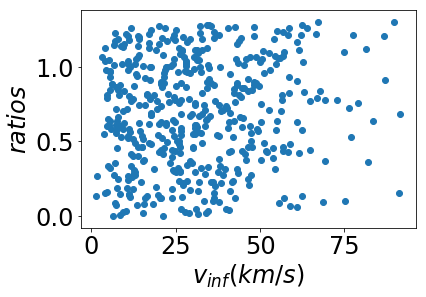

In [17]:
##Check the pericenter distance of giant collision
coll_r0_bin = np.take(prop_init['r0'], index_coll_bin)
coll_r1_bin = np.take(prop_init['r1'], index_coll_bin)
coll_rperi_bin = np.take(prop_init['rperi'], index_coll_bin)
coll_vinf_bin = np.take(prop_init['vinf'], index_coll_bin)

coll_r0_des = np.take(prop_des['r0'], index_coll_des)
coll_r1_des = np.take(prop_des['r1'], index_coll_des)
coll_rperi_des = np.take(prop_des['rperi'], index_coll_des)
coll_vinf_des = np.take(prop_des['vinf'], index_coll_des)

coll_r0 = np.concatenate((coll_r0_bin, coll_r0_des))
coll_r1 = np.concatenate((coll_r1_bin, coll_r1_des))
coll_rperi = np.concatenate((coll_rperi_bin, coll_rperi_des))

coll_vinf = np.concatenate((coll_vinf_bin, coll_vinf_des))

ratio = coll_rperi/(coll_r0+coll_r1)

for i in range(len(ratio)):
    if ratio[i]>1.3:
        print(coll_r0[i], coll_r1[i])

plt.figure()
#plt.scatter(coll_rperi, ratio)
plt.scatter(coll_vinf, ratio)
#plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.xlabel(r'$v_{inf}(km/s)$')
#plt.xscale('log')
plt.ylabel(r'$ratios$')

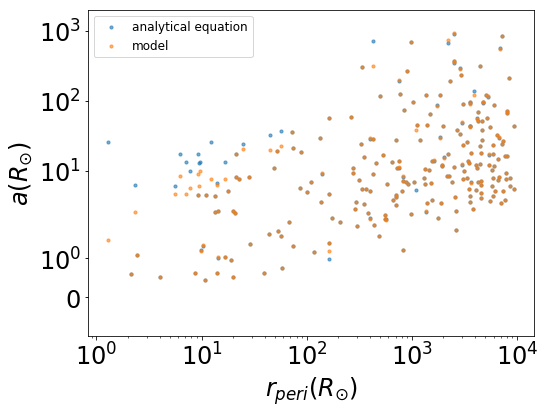

In [6]:
##Check the CE outcomes of giant-giant collisions and RLOF

def coll_CE(Mrg, Mint, Mwd, Rrg, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    ##a_f in unit of solar radius
    return(1.0/(2.0*Mrg*(Mrg-Mwd)/(Mwd*Mint*alpha1*lambdaf*Rrg)-(Mrg+Mint)/(Gconst_sun*PC_Rsun*Mwd*Mint*alpha1)*vinf*vinf))


def coll_CE_twogiants(M1, M2, Mc1, Mc2, R1, R2, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    E_bindi = Gconst_sun*PC_Rsun/lambdaf*(M1*(M1-Mc1)/R1+M2*(M2-Mc2)/R2)
    E_orbi = 0.5*(M1+M2)*vinf*vinf

    af = Gconst_sun*PC_Rsun*Mc1*Mc2*alpha1/(2*(E_bindi-E_orbi))

    return af

def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl


coll_m0_init = np.take(prop_init['m0'], index_coll_bin)
coll_m1_init = np.take(prop_init['m1'], index_coll_bin)
coll_r0_init = np.take(prop_init['r0'], index_coll_bin)
coll_r1_init = np.take(prop_init['r1'], index_coll_bin)
coll_k0_init = np.take(prop_init['k0'], index_coll_bin)
coll_k1_init = np.take(prop_init['k1'], index_coll_bin)

coll_m0_finl = np.take(prop_finl['m0'], index_coll_bin)
coll_m1_finl = np.take(prop_finl['m1'], index_coll_bin)
coll_r0_finl = np.take(prop_finl['r0'], index_coll_bin)
coll_r1_finl = np.take(prop_finl['r1'], index_coll_bin)

coll_vinf = np.take(prop_init['vinf'], index_coll_bin)
coll_sma = np.take(prop_finl['sma'], index_coll_bin)*AU_Rsun
coll_rperi = np.take(prop_init['rperi'], index_coll_bin)

ce_af = []
for i in range(len(coll_k0_init)):
    if (2<=coll_k0_init[i]<=9 and coll_k0_init[i]!=7) and (2<=coll_k1_init[i]<=9 and coll_k1_init[i]!=7):
        af_temp = coll_CE_twogiants(coll_m0_init[i], coll_m1_init[i], coll_m0_finl[i], coll_m1_finl[i],
                                   coll_r0_init[i], coll_r1_init[i], coll_vinf[i])
        ce_af.append(af_temp)
    elif 2<=coll_k0_init[i]<=9 and coll_k0_init[i]!=7:
        af_temp = coll_CE(coll_m0_init[i], coll_m1_init[i], coll_m0_finl[i], coll_r0_init[i], coll_vinf[i])
        ce_af.append(af_temp)
    elif 2<=coll_k1_init[i]<=9 and coll_k1_init[i]!=7:
        af_temp = coll_CE(coll_m1_init[i], coll_m0_init[i], coll_m1_finl[i], coll_r1_init[i], coll_vinf[i])
        ce_af.append(af_temp)
        
        
plt.figure(figsize=(8, 6))
plt.scatter(coll_rperi, ce_af, s = 10, alpha=0.6, label='analytical equation')
plt.scatter(coll_rperi, coll_sma, s = 10, alpha=0.6, label='model')
plt.yscale('symlog')
plt.xscale('log')
plt.ylim(-1, 2000)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$a(R_{\odot})$')
plt.legend(loc='best', fontsize=12)

#ratio = coll_sma/(coll_r0_finl+coll_r1_finl)
#plt.figure()
#plt.scatter(coll_rperi, ratio)
#plt.yscale('log')
#plt.xscale('log')
#print(np.min(coll_sma)*AU_Rsun, np.min(ratio))

for i in range(len(coll_m0_finl)):
    rl0 = rochradius(coll_m0_finl[i], coll_m1_finl[i], coll_sma[i])
    rl1 = rochradius(coll_m1_finl[i], coll_m0_finl[i], coll_sma[i])
    if rl0<=coll_r0_finl[i] or rl1<=coll_r1_finl[i]:
        print('Oops, something is wrong')

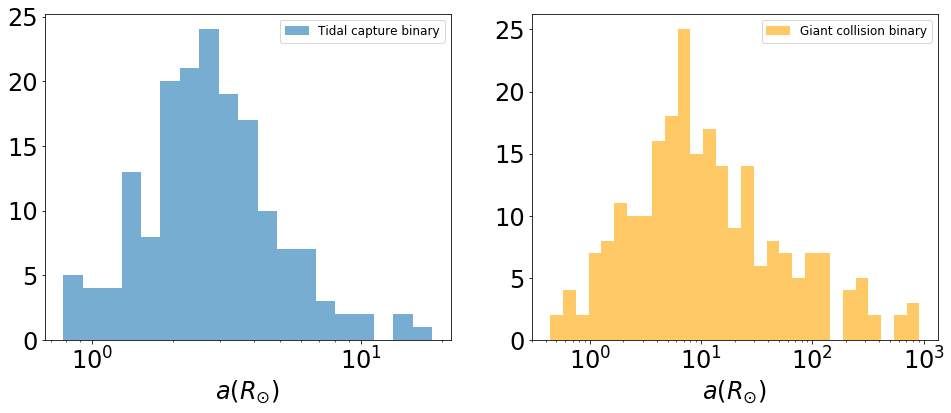

In [21]:
##Plot the distribution of SMA
tc_sma = np.take(prop_finl['sma'], index_tc_bin)*AU_Rsun
coll_sma = np.take(prop_finl['sma'], index_coll_bin)*AU_Rsun
tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
coll_rperi = np.take(prop_init['rperi'], index_coll_bin)

fig, axs = plt.subplots(ncols = 2, figsize=(16, 6))
axs[0].hist(tc_sma, bins=np.logspace(np.log10(min(tc_sma)), np.log10(max(tc_sma)), 20), alpha=0.6, label = 'Tidal capture binary')
#axs[0].hist(tc_rperi, bins=np.logspace(np.log10(min(tc_rperi)), np.log10(max(tc_rperi)), 20), alpha=0.6)

axs[0].set_xscale('log')
axs[0].locator_params(axis='x', numticks = 6)
axs[0].set_xlabel(r'$a(R_{\odot})$')
axs[0].legend(loc='best', fontsize = 12)

axs[1].hist(coll_sma, bins=np.logspace(np.log10(min(coll_sma)), np.log10(max(coll_sma)), 30), color = 'orange', alpha=0.6, label = 'Giant collision binary')
axs[1].set_xscale('log')
axs[1].locator_params(axis='x', numticks = 6)
axs[1].set_xlabel(r'$a(R_{\odot})$')
axs[1].legend(loc='best', fontsize = 12)


In [22]:
##Check the hardness of tidal capture binaries
tc_hardness = []; coll_hardness = []
tc_length_ratio = []; coll_length_ratio = []

mave = 1.; v_sigma = 10. ##mave in solar unit, v_sigma in km/s
kt = mave*v_sigma**2

nloc = 10000.   ##pc^-3
length_factor = 0.1
lloc = length_factor*nloc**(-1/3)*PC_AU

for i in range(len(index_tc_bin)):
    number_tc = int(index_tc_bin[i])
    ebind_temp = Gconst_sun*prop_finl['m0'][number_tc]*prop_finl['m1'][number_tc]/(prop_finl['sma'][number_tc]/PC_AU)
    tc_hardness.append(ebind_temp/kt)   
    tc_length_ratio.append(prop_finl['sma'][number_tc]/lloc)


for j in range(len(index_coll_bin)):
    number_coll = int(index_coll_bin[j])
    ebind_temp = Gconst_sun*prop_finl['m0'][number_coll]*prop_finl['m1'][number_coll]/(prop_finl['sma'][number_coll]/PC_AU)
    coll_hardness.append(ebind_temp/kt)
    
    coll_length_ratio.append(prop_finl['sma'][number_coll]/lloc)
    

#print(tc_hardness, coll_hardness)
print(np.mean(tc_hardness), np.mean(coll_hardness))
#print(tc_length_ratio, coll_length_ratio)
print(np.mean(tc_length_ratio), np.mean(coll_length_ratio))

1050.989903872165 1053.6734122350895
1.596651822978918e-05 0.00022597546135007693


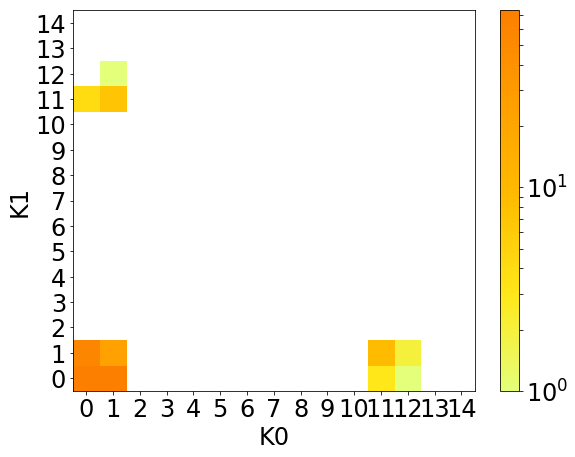

In [28]:
##Check sticky sphere collisions
sticky_k0 = np.take(all_sscoll['k0'], index_sticky)
sticky_k1 = np.take(all_sscoll['k1'], index_sticky)

K0=[x - 0.5 for x in sticky_k0]
K1=[Y - 0.5 for Y in sticky_k1]
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='Wistia')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()

In [5]:
##Check tidal capture that leads to tidal disruption
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl
    

tde_m0 = np.take(all_sscoll['m0'], index_tde)
tde_m1 = np.take(all_sscoll['m1'], index_tde)
tde_r0 = np.take(all_sscoll['r0'], index_tde)
tde_r1 = np.take(all_sscoll['r1'], index_tde)
tde_k0 = np.take(all_sscoll['k0'], index_tde)
tde_k1 = np.take(all_sscoll['k1'], index_tde)
tde_id0 = np.take(all_sscoll['id0'], index_tde)
tde_id1 = np.take(all_sscoll['id1'], index_tde)
tde_sma = np.take(all_sscoll['rperi'], index_tde)*2./AU_Rsun

#print(tde_k0, tde_k1)
#print(tde_id0, tde_id1)

for i in range(len(tde_m0)):
    rl0 = rochradius(tde_m0[i], tde_m1[i], tde_sma[i])
    rl1 = rochradius(tde_m1[i], tde_m0[i], tde_sma[i])
    if rl1>=tde_r1[i] and rl0>=tde_r0[i]:
        print('Oops, something is wrong')

In [11]:
##Check giant-giant collision that lead to merger
##Can't do this. Doesn't have core mass

#def coll_CE(Mrg, Mint, Mwd, Rrg, vinf):
#    alpha1 = 1.0
#    lambdaf = 0.5
#
#    ##a_f in unit of solar radius
#    return 1.0/(2.0*Mrg*(Mrg-Mwd)/(Mwd*Mint*alpha1*lambdaf*Rrg)-(Mrg+Mint)/(Gconst_sun*PC_Rsun*Mwd*Mint*alpha1)*vinf*vinf)
#
#
#def coll_CE_twogiants(M1, M2, Mc1, Mc2, R1, R2, vinf):
#    alpha1 = 1.0
#    lambdaf = 0.5
#
#    E_bindi = Gconst_sun*PC_Rsun/lambdaf*(M1*(M1-Mc1)/R1+M2*(M2-Mc2)/R2)
#    E_orbi = 0.5*(M1+M2)*vinf*vinf
#
#    af = Gconst_sun*PC_Rsun*Mc1*Mc2*alpha1/(2*(E_bindi-E_orbi))
#
#    return af
#
#def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
#    q = m0/m1   
#    p = pow(q, 1.0/3.0)
#    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
#    return rl


#gmerge_m0 = np.take(all_sscoll['m0'], index_gmerge)
#gmerge_m1 = np.take(all_sscoll['m1'], index_gmerge)
#gmerge_r0 = np.take(all_sscoll['r0'], index_gmerge)
#gmerge_r1 = np.take(all_sscoll['r1'], index_gmerge)
#gmerge_k0 = np.take(all_sscoll['k0'], index_gmerge)
#gmerge_k1 = np.take(all_sscoll['k1'], index_gmerge)
#gmerge_id0 = np.take(all_sscoll['id0'], index_gmerge)
#gmerge_id1 = np.take(all_sscoll['id1'], index_gmerge)
#
#coll_m0_des = np.take(prop_des['m0'], index_coll_des)
#coll_m1_des = np.take(prop_des['m1'], index_coll_des)
#coll_r0_des = np.take(prop_des['r0'], index_coll_des)
#coll_r1_des = np.take(prop_des['r1'], index_coll_des)
#coll_k0_des = np.take(prop_des['k0'], index_coll_des)
#coll_k1_des = np.take(prop_des['k1'], index_coll_des)
#coll_id0_des = np.take(prop_des['id0'], index_coll_des)
#coll_id1_des = np.take(prop_des['id1'], index_coll_des)
#coll_vinf_des = np.take(prop_des['vinf'], index_coll_des)
#coll_rperi_des = np.take(prop_des['rperi'], index_coll_des)

#print(gmerge_id0-coll_id0_des)

#ce_af = []
#for i in range(len(coll_k0_des)):
#    if (2<=coll_k0_des[i]<=9 and coll_k0_des[i]!=7) and (2<=coll_k1_des[i]<=9 and coll_k1_des[i]!=7):
#        af_temp = coll_CE_twogiants(coll_m0_des[i], coll_m1_des[i], gmerge_m0[i], gmerge_m1[i],
#                                   coll_r0_des[i], coll_r1_des[i], coll_vinf_des[i])
#        ce_af.append(af_temp)
#        
#        rl0 = rochradius(gmerge_m0[i], gmerge_m1[i], af_temp)
#        rl1 = rochradius(gmerge_m1[i], gmerge_m0[i], af_temp)
#        if rl1>=gmerge_r1[i] and rl0>=gmerge_r0[i]:
#            print('Oops, something is wrong', af_temp, gmerge_r0[i], gmerge_r1[i], gmerge_id0[i], gmerge_id1[i], gmerge_k0[i], gmerge_k1[i], coll_rperi_des[i])
#            
#    elif 2<=coll_k0_des[i]<=9 and coll_k0_des[i]!=7:
#        af_temp = coll_CE(coll_m0_des[i], coll_m1_des[i], gmerge_m0[i], coll_r0_des[i], coll_vinf_des[i])
#        ce_af.append(af_temp)
#        
#        rl0 = rochradius(gmerge_m0[i], gmerge_m1[i], af_temp)
#        rl1 = rochradius(gmerge_m1[i], gmerge_m0[i], af_temp)
#        if rl1>=gmerge_r1[i] and rl0>=gmerge_r0[i]:
#            print('Oops, something is wrong', af_temp, gmerge_r0[i], gmerge_r1[i], gmerge_id0[i], gmerge_id1[i], gmerge_k0[i], gmerge_k1[i], coll_rperi_des[i])
#            
#    elif 2<=coll_k1_des[i]<=9 and coll_k1_des[i]!=7:
#        af_temp = coll_CE(coll_m1_des[i], coll_m0_des[i], gmerge_m1[i], coll_r1_des[i], coll_vinf_des[i])
#        ce_af.append(af_temp)  
#        
#        rl0 = rochradius(gmerge_m0[i], gmerge_m1[i], af_temp)
#        rl1 = rochradius(gmerge_m1[i], gmerge_m0[i], af_temp)
#        if rl1>=gmerge_r1[i] and rl0>=gmerge_r0[i]:
#            print('Oops, something is wrong', af_temp, gmerge_r0[i], gmerge_r1[i], gmerge_id0[i], gmerge_id1[i], gmerge_k0[i], gmerge_k1[i], coll_rperi_des[i])
#            
#print(len(coll_k0_des))

##Something is wrong but I don't know why!

Text(0.5,0.98,'Tidal Capture')

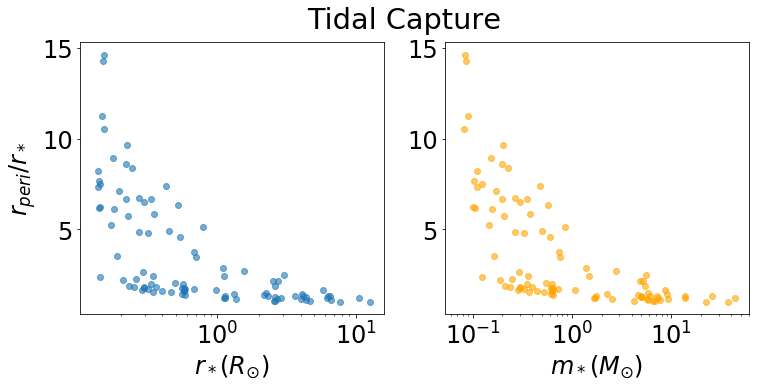

In [3]:
##M-Rperi relation of tidal capture
tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
tc_k0 = np.take(prop_init['k0'], index_tc_bin)
tc_k1 = np.take(prop_init['k1'], index_tc_bin)
tc_m0 = np.take(prop_init['m0'], index_tc_bin)
tc_m1 = np.take(prop_init['m1'], index_tc_bin)
tc_r0 = np.take(prop_init['r0'], index_tc_bin)
tc_r1 = np.take(prop_init['r1'], index_tc_bin)

rstar = []; mstar = []
for i in range(len(tc_k0)):
    if tc_k0[i] < 10 and tc_k1[i] < 10:
        rstar.append(max(tc_r0[i], tc_r1[i]))
        mstar.append(max(tc_m0[i], tc_m1[i]))
        
    elif tc_k0[i] < 10:
        rstar.append(tc_r0[i]); mstar.append(tc_m0[i])
        
    elif tc_k1[i] < 10:
        rstar.append(tc_r1[i]); mstar.append(tc_m1[i])
    
    else:
        print("What's going on?")
        
rstar = np.array(rstar); mstar = np.array(mstar)    
fig, axs = plt.subplots(ncols=2, figsize = (12, 5))
axs[0].scatter(rstar, tc_rperi/rstar, alpha=0.6)
axs[1].scatter(mstar, tc_rperi/rstar, color = 'orange', alpha=0.6)

axs[0].set_ylabel(r'$r_{peri}/r_*$')
axs[0].set_xlabel(r'$r_* (R_{\odot})$')
#axs[1].set_ylabel(r'$r_{peri}/r_*$')
axs[1].set_xlabel(r'$m_* (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

plt.suptitle('Tidal Capture')

1952 1946 3898
151 39 190


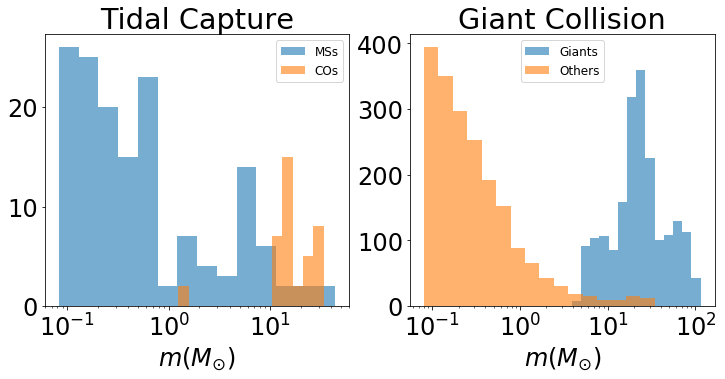

In [4]:
##Mass distribution of giant collision and tidal capture
tc_k0 = np.take(prop_init['k0'], index_tc_bin)
tc_k1 = np.take(prop_init['k1'], index_tc_bin)
tc_m0 = np.take(prop_init['m0'], index_tc_bin)
tc_m1 = np.take(prop_init['m1'], index_tc_bin)
coll_m0 = np.take(prop_init['m0'], index_coll_bin)
coll_m1 = np.take(prop_init['m1'], index_coll_bin)
coll_k0 = np.take(prop_init['k0'], index_coll_bin)
coll_k1 = np.take(prop_init['k1'], index_coll_bin)

tc_totm = np.concatenate((tc_m0, tc_m1))
coll_totm = np.concatenate((coll_m0, coll_m1))

coll_giantm = []; coll_otherm = []
for i in range(len(coll_k0)):
    if 2<=coll_k0[i]<=9 and coll_k0[i]!=7:
        coll_giantm.append(coll_m0[i])
    else:
        coll_otherm.append(coll_m0[i])
    
    if 2<=coll_k1[i]<=9 and coll_k1[i]!=7:
        coll_giantm.append(coll_m1[i])
    else:
        coll_otherm.append(coll_m1[i])
print(len(coll_giantm), len(coll_otherm), len(coll_totm))

tc_msm = []; tc_com = []
for i in range(len(tc_k0)):
    if tc_k0[i] <= 1:
        tc_msm.append(tc_m0[i])
    else:
        tc_com.append(tc_m0[i])
        
    if tc_k1[i] <= 1:
        tc_msm.append(tc_m1[i])
    else:
        tc_com.append(tc_m1[i])
        
print(len(tc_msm), len(tc_com), len(tc_totm))

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
#axs[0].hist(tc_totm, bins = np.logspace(np.log10(min(tc_totm)), np.log10(max(tc_totm)), 20), label = 'Tidal Capture', alpha=0.6)
#axs[1].hist(coll_totm, bins = np.logspace(np.log10(min(coll_totm)), np.log10(max(coll_totm)), 20), histtype= 'step', color = 'k', lw = 4, alpha=0.6)
axs[0].hist(tc_msm, bins = np.logspace(np.log10(min(tc_msm)), np.log10(max(tc_msm)), 15), alpha=0.6, label = 'MSs')
axs[0].hist(tc_com, bins = np.logspace(np.log10(min(tc_com)), np.log10(max(tc_com)), 15), alpha=0.6, label = 'COs')

axs[1].hist(coll_giantm, bins = np.logspace(np.log10(min(coll_giantm)), np.log10(max(coll_giantm)), 15), alpha=0.6, label = 'Giants')
axs[1].hist(coll_otherm, bins = np.logspace(np.log10(min(coll_otherm)), np.log10(max(coll_otherm)), 17), alpha=0.6, label = 'Others')


axs[0].set_xlabel(r'$m (M_{\odot})$')
axs[1].set_xlabel(r'$m (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=12)
axs[1].legend(loc='best', fontsize=12)


8813 8803 17616
157 45 202


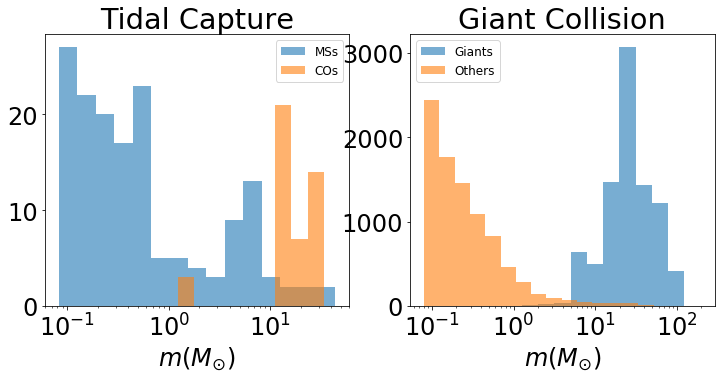

In [12]:
##All mass distribution of giant collision and tidal capture (including merging systems)
tc_bin_m0 = np.take(prop_init['m0'], index_tc_bin)
tc_bin_m1 = np.take(prop_init['m1'], index_tc_bin)
tc_bin_k0 = np.take(prop_init['k0'], index_tc_bin)
tc_bin_k1 = np.take(prop_init['k1'], index_tc_bin)
coll_bin_m0 = np.take(prop_init['m0'], index_coll_bin)
coll_bin_m1 = np.take(prop_init['m1'], index_coll_bin)
coll_bin_k0 = np.take(prop_init['k0'], index_coll_bin)
coll_bin_k1 = np.take(prop_init['k1'], index_coll_bin)

tc_des_m0 = np.take(prop_des['m0'], index_tc_des)
tc_des_m1 = np.take(prop_des['m1'], index_tc_des)
tc_des_k0 = np.take(prop_des['k0'], index_tc_des)
tc_des_k1 = np.take(prop_des['k1'], index_tc_des)
coll_des_m0 = np.take(prop_des['m0'], index_coll_des)
coll_des_m1 = np.take(prop_des['m1'], index_coll_des)
coll_des_k0 = np.take(prop_des['k0'], index_coll_des)
coll_des_k1 = np.take(prop_des['k1'], index_coll_des)

tc_all_m0 = np.concatenate((tc_bin_m0, tc_des_m0))
tc_all_m1 = np.concatenate((tc_bin_m1, tc_des_m1))
tc_all_k0 = np.concatenate((tc_bin_k0, tc_des_k0))
tc_all_k1 = np.concatenate((tc_bin_k1, tc_des_k1))
coll_all_m0 = np.concatenate((coll_bin_m0, coll_des_m0))
coll_all_m1 = np.concatenate((coll_bin_m1, coll_des_m1))
coll_all_k0 = np.concatenate((coll_bin_k0, coll_des_k0))
coll_all_k1 = np.concatenate((coll_bin_k1, coll_des_k1))


tc_all_totm = np.concatenate((tc_all_m0, tc_all_m1))
coll_all_totm = np.concatenate((coll_all_m0, coll_all_m1))

coll_all_giantm = []; coll_all_otherm = []
for i in range(len(coll_all_k0)):
    if 2<=coll_all_k0[i]<=9 and coll_all_k0[i]!=7:
        coll_all_giantm.append(coll_all_m0[i])
    else:
        coll_all_otherm.append(coll_all_m0[i])
    
    if 2<=coll_all_k1[i]<=9 and coll_all_k1[i]!=7:
        coll_all_giantm.append(coll_all_m1[i])
    else:
        coll_all_otherm.append(coll_all_m1[i])
print(len(coll_all_giantm), len(coll_all_otherm), len(coll_all_totm))

tc_all_msm = []; tc_all_com = []
for i in range(len(tc_all_k0)):
    if tc_all_k0[i] <= 1 or tc_all_k0[i] == 7:
        tc_all_msm.append(tc_all_m0[i])
    else:
        tc_all_com.append(tc_all_m0[i])
        
    if tc_all_k1[i] <= 1 or tc_all_k1[i] == 7:
        tc_all_msm.append(tc_all_m1[i])
    else:
        tc_all_com.append(tc_all_m1[i])
        
print(len(tc_all_msm), len(tc_all_com), len(tc_all_totm))

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
#axs[0].hist(tc_totm, bins = np.logspace(np.log10(min(tc_totm)), np.log10(max(tc_totm)), 20), label = 'Tidal Capture', alpha=0.6)
#axs[1].hist(coll_totm, bins = np.logspace(np.log10(min(coll_totm)), np.log10(max(coll_totm)), 20), histtype= 'step', color = 'k', lw = 4, alpha=0.6)
axs[0].hist(tc_all_msm, bins = np.logspace(np.log10(min(tc_all_msm)), np.log10(max(tc_all_msm)), 16), alpha=0.6, label = 'MSs')
axs[0].hist(tc_all_com, bins = np.logspace(np.log10(min(tc_all_com)), np.log10(max(tc_all_com)), 10), alpha=0.6, label = 'COs')

axs[1].hist(coll_all_giantm, bins = np.logspace(np.log10(min(coll_all_giantm)), np.log10(max(coll_all_giantm)), 12), alpha=0.6, label = 'Giants')
axs[1].hist(coll_all_otherm, bins = np.logspace(np.log10(min(coll_all_otherm)), np.log10(max(coll_all_otherm)), 17), alpha=0.6, label = 'Others')

axs[0].set_xlabel(r'$m (M_{\odot})$')
axs[1].set_xlabel(r'$m (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=12)
axs[1].legend(loc='best', fontsize=12)


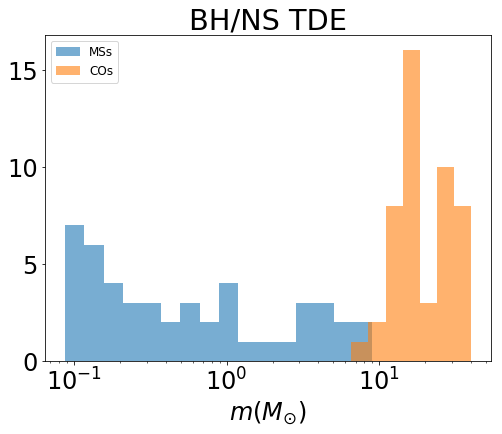

In [23]:
##Mass distribution of BHNS TDE
bhns_tde_m0 = np.take(all_sscoll['m0'], index_bhns_tde)
bhns_tde_m1 = np.take(all_sscoll['m1'], index_bhns_tde)
bhns_tde_k0 = np.take(all_sscoll['k0'], index_bhns_tde)
bhns_tde_k1 = np.take(all_sscoll['k1'], index_bhns_tde)

bhns_tde_msm = []; bhns_tde_com = []
for i in range(len(bhns_tde_k0)):
    if bhns_tde_k0[i] <= 1:
        bhns_tde_msm.append(bhns_tde_m0[i])
    else:
        bhns_tde_com.append(bhns_tde_m0[i])
        
    if bhns_tde_k1[i] <= 1:
        bhns_tde_msm.append(bhns_tde_m1[i])
    else:
        bhns_tde_com.append(bhns_tde_m1[i])
        
        
fig, axs = plt.subplots(figsize = (8,6))

axs.hist(bhns_tde_msm, bins = np.logspace(np.log10(min(bhns_tde_msm)), np.log10(max(bhns_tde_msm)), 17), alpha=0.6, label = 'MSs')
axs.hist(bhns_tde_com, bins = np.logspace(np.log10(min(bhns_tde_com)), np.log10(max(bhns_tde_com)), 8), alpha=0.6, label = 'COs')


axs.set_xlabel(r'$m (M_{\odot})$')
axs.set_xscale('log')
axs.set_title('BH/NS TDE')
axs.legend(loc='best', fontsize=12)

In [41]:
##Check binary types of tidal capture and giant collision binaries
tc_k0_finl = np.take(prop_finl['k0'], index_tc_bin)
tc_k1_finl = np.take(prop_finl['k1'], index_tc_bin)
tc_k0_init = np.take(prop_init['k0'], index_tc_bin)
tc_k1_init = np.take(prop_init['k1'], index_tc_bin)


coll_k0_finl = np.take(prop_finl['k0'], index_coll_bin)
coll_k1_finl = np.take(prop_finl['k1'], index_coll_bin)
coll_k0_init = np.take(prop_init['k0'], index_coll_bin)
coll_k1_init = np.take(prop_init['k1'], index_coll_bin)

tc_init = np.zeros([15, 15]); tc_finl = np.zeros([15, 15])
coll_init = np.zeros([15, 15]); coll_finl = np.zeros([15, 15])

from IPython.display import display_html, display
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)
    

for i in range(len(tc_k0_init)):
    x_tmp = tc_k0_init[i]; y_tmp = tc_k1_init[i]
    if x_tmp < y_tmp: 
        xvalue = x_tmp; yvalue = y_tmp
    else: 
        xvalue = y_tmp; yvalue = x_tmp
        
    tc_init[xvalue, yvalue]+=1
    
for x in range(len(tc_k0_finl)):
    x_tmp = tc_k0_finl[x]; y_tmp = tc_k1_finl[x]
    if x_tmp < y_tmp: 
        xvalue = x_tmp; yvalue = y_tmp
    else: 
        xvalue = y_tmp; yvalue = x_tmp
        
    tc_finl[xvalue, yvalue]+=1
    
for j in range(len(coll_k0_init)):
    x_tmp = coll_k0_init[j]; y_tmp = coll_k1_init[j]
    if x_tmp < y_tmp: 
        xvalue = x_tmp; yvalue = y_tmp
    else: 
        xvalue = y_tmp; yvalue = x_tmp
        
    coll_init[xvalue, yvalue]+=1

for y in range(len(coll_k0_finl)):
    x_tmp = coll_k0_finl[y]; y_tmp = coll_k1_finl[y]
    if x_tmp < y_tmp: 
        xvalue = x_tmp; yvalue = y_tmp
    else: 
        xvalue = y_tmp; yvalue = x_tmp
        
    coll_finl[xvalue, yvalue]+=1
    

df1 = pd.DataFrame(tc_init, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df2 = pd.DataFrame(tc_finl, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df3 = pd.DataFrame(coll_init, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df4 = pd.DataFrame(coll_finl, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)

display_side_by_side(df1, df2)
display_side_by_side(df3, df4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,42,30,0,0,0,0,0,0,0,0,0,30,4,1,36
1,0,3,0,0,0,0,0,0,0,0,0,10,1,0,12
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,7,132,7,9,0,0,0,0,0,0,0,0
1,0,0,0,3,44,5,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,5,1,0,2
4,0,0,0,0,0,0,0,0,0,0,0,7,0,0,10
5,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


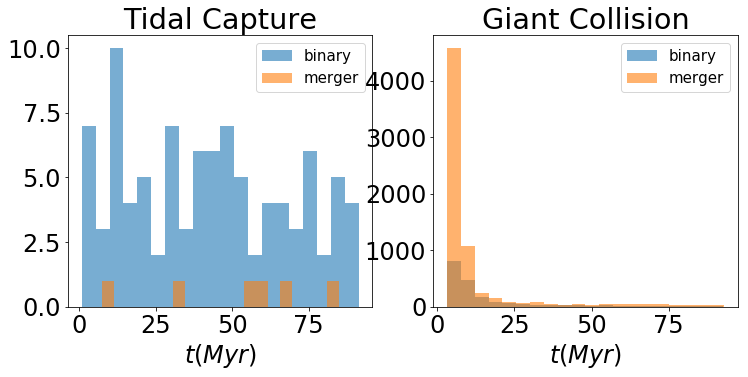

In [5]:
### Check time distribution of tidal capture and giant collision
tconv = dyn.conv('t', testpath+'initial.conv.sh')

tc_bin_time = np.take(prop_init['time'], index_tc_bin)*tconv
coll_bin_time = np.take(prop_init['time'], index_coll_bin)*tconv
tc_des_time = np.take(prop_des['time'], index_tc_des)*tconv
coll_des_time = np.take(prop_des['time'], index_coll_des)*tconv

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
axs[0].hist(tc_bin_time, bins = 20, alpha = 0.6, label = 'binary')
axs[0].hist(tc_des_time, bins = 20, alpha = 0.6, label = 'merger')
axs[1].hist(coll_bin_time, bins = 20, alpha = 0.6, label = 'binary')
axs[1].hist(coll_des_time, bins = 20, alpha = 0.6, label = 'merger')

axs[0].set_xlabel(r'$t(Myr)$')
axs[1].set_xlabel(r'$t(Myr)$')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=15)
axs[1].legend(loc='best', fontsize=15)

In [3]:
##Extract cluster properties from the tidal capture model and the standard model
path_tc = testpath
path_comp = '/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/8e5/'

dyn_tc = np.genfromtxt(path_tc+'initial.dyn.dat')
bin_tc = np.genfromtxt(path_tc+'initial.bin.dat')
dyn_comp = np.genfromtxt(path_comp+'initial.dyn.dat')
bin_comp = np.genfromtxt(path_comp+'initial.bin.dat')
bh_tc = np.genfromtxt(path_tc+'initial.bh.dat')
bh_comp = np.genfromtxt(path_comp+'initial.bh.dat')
ns_tc = np.genfromtxt(path_tc+'initial.ns.dat')
ns_comp = np.genfromtxt(path_comp+'initial.ns.dat')


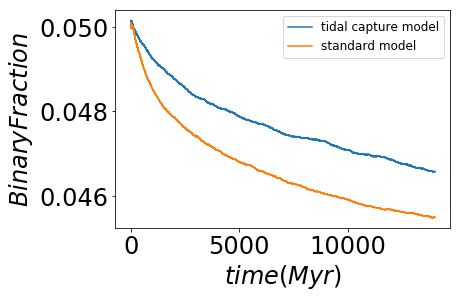

In [39]:
##Compare binary fraction of tidal capture model and standard model
N_tc = dyn_tc[:,3]; t_tc = dyn_tc[:,0]; Nb_tc = bin_tc[:,1]
N_comp = dyn_comp[:,3]; t_comp = dyn_comp[:,0]; Nb_comp = bin_comp[:,1]

conv_tc = dyn.conv('t', path_tc+'initial.conv.sh')
conv_comp = dyn.conv('t', path_comp+'initial.conv.sh')

tmyr_tc = conv_tc*np.array(t_tc)
tmyr_comp = conv_comp*np.array(t_comp)
binfrac_tc = np.array(Nb_tc)/np.array(N_tc)
binfrac_comp = np.array(Nb_comp)/np.array(N_comp)

plt.figure()
plt.plot(tmyr_tc, binfrac_tc, label = 'tidal capture model')
plt.plot(tmyr_comp, binfrac_comp, label = 'standard model')

plt.xlabel(r'$time(Myr)$')
plt.ylabel(r'$Binary Fraction$')

plt.legend(loc='best', fontsize=12)

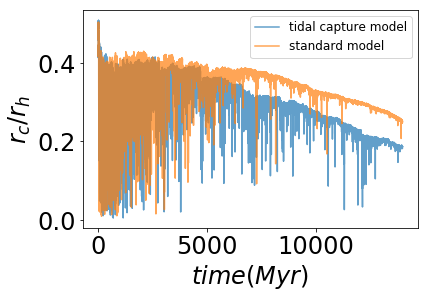

In [40]:
##Compare rc/rh of tidal capture model and standard model
rc_tc = dyn_tc[:,7]; rh_tc = dyn_tc[:,20]; t_tc = dyn_tc[:,0]
rc_comp = dyn_comp[:,7]; rh_comp = dyn_comp[:,20]; t_comp = dyn_comp[:,0]

tmyr_tc = conv_tc*np.array(t_tc)
tmyr_comp = conv_comp*np.array(t_comp)
r_ratio_tc = np.array(rc_tc)/np.array(rh_tc)
r_ratio_comp = np.array(rc_comp)/np.array(rh_comp)

plt.figure()
plt.plot(tmyr_tc, r_ratio_tc, label = 'tidal capture model', alpha=0.7)
plt.plot(tmyr_comp, r_ratio_comp, label = 'standard model', alpha=0.7)

plt.xlabel(r'$time(Myr)$')
plt.ylabel(r'$r_c/r_h$')

plt.legend(loc='best', fontsize=12)

484615.0 484844.0


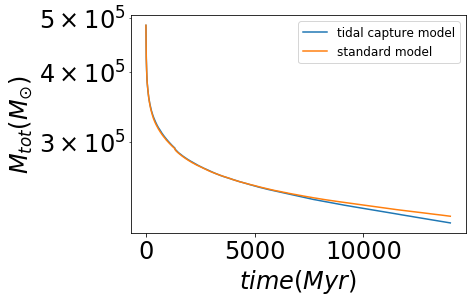

In [4]:
##Compare the mass evolution of the two models
m_tc = dyn_tc[:,4]; t_tc = dyn_tc[:,0]
m_comp = dyn_comp[:,4]; t_comp = dyn_comp[:,0]

tconv_tc = dyn.conv('t', path_tc+'initial.conv.sh')
tconv_comp = dyn.conv('t', path_comp+'initial.conv.sh')
mconv_tc = dyn.conv('m', path_tc+'initial.conv.sh')
mconv_comp = dyn.conv('m', path_comp+'initial.conv.sh')
print(mconv_tc, mconv_comp)

tmyr_tc = tconv_tc*np.array(t_tc)
tmyr_comp = tconv_comp*np.array(t_comp)
msun_tc = mconv_tc*np.array(m_tc)
msun_comp = mconv_comp*np.array(m_comp)

plt.figure()
plt.plot(tmyr_tc, msun_tc, label = 'tidal capture model')
plt.plot(tmyr_comp, msun_comp, label = 'standard model')

plt.yscale('log')

plt.xlabel(r'$time(Myr)$')
plt.ylabel(r'$M_{tot}(M_{\odot})$')
plt.legend(loc='best', fontsize=12)

(-1, 30)

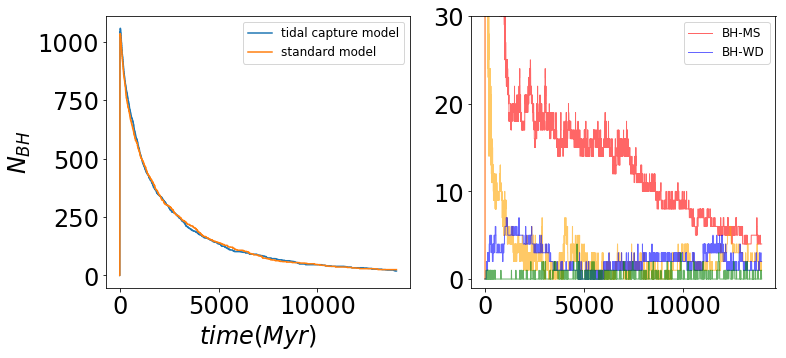

In [42]:
##Comapre number of BH
t_tc = bh_tc[:,1]; Nbh_tc = bh_tc[:,2]
Nbhms_tc = bh_tc[:,10]; Nbhwd_tc = bh_tc[:,8]

t_comp = bh_comp[:,1]; Nbh_comp = bh_comp[:,2]
Nbhms_comp = bh_comp[:,10]; Nbhwd_comp = bh_comp[:,8]

conv_tc = dyn.conv('t', path_tc+'initial.conv.sh')
conv_comp = dyn.conv('t', path_comp+'initial.conv.sh')

tmyr_tc = conv_tc*np.array(t_tc)
tmyr_comp = conv_comp*np.array(t_comp)

cs = ['r', 'b']
fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
axs[0].plot(tmyr_tc, Nbh_tc, label = 'tidal capture model')
axs[0].plot(tmyr_comp, Nbh_comp, label = 'standard model')
axs[0].set_xlabel(r'$time(Myr)$')
axs[0].set_ylabel(r'$N_{BH}$')
axs[0].legend(loc='best', fontsize = 12)

axs[1].plot(tmyr_tc, Nbhms_tc, color = cs[0], label = 'BH-MS', lw=1, alpha=0.6)
axs[1].plot(tmyr_comp, Nbhms_comp, color = 'orange', lw=1, alpha=0.6)
axs[1].plot(tmyr_tc, Nbhwd_tc, color = cs[1], label = 'BH-WD', lw=1, alpha=0.6)
axs[1].plot(tmyr_comp, Nbhwd_comp, color = 'green', lw=1, alpha=0.6)
axs[1].legend(loc='best', fontsize = 12)
#axs[1].set_yscale('symlog')
axs[1].set_ylim(-1, 30)


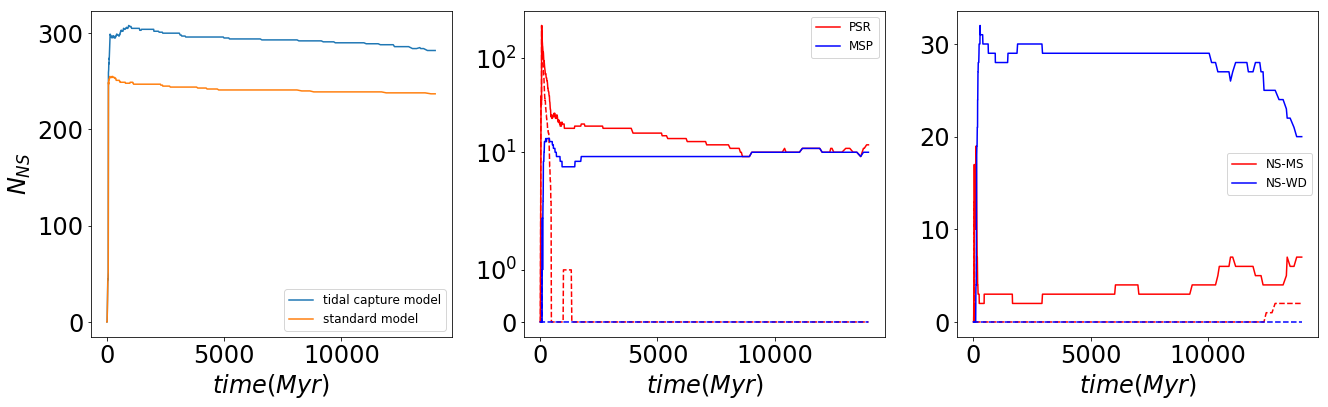

In [43]:
##Compare the number of pulsars and neutron star binaries in general in the two models
t_tc = ns_tc[:,0]; Nns_tc = ns_tc[:,1]
Nnsms_tc = ns_tc[:,10]; Nnswd_tc = ns_tc[:,9]
Npsr_tc = ns_tc[:,5]; Nmsp_tc = ns_tc[:,6]

t_comp = ns_comp[:,0]; Nns_comp = ns_comp[:,1]
Nnsms_comp = ns_comp[:,10]; Nnswd_comp = ns_comp[:,9]
Npsr_comp = ns_comp[:,5]; Nmsp_comp = ns_comp[:,6]

conv_tc = dyn.conv('t', path_tc+'initial.conv.sh')
conv_comp = dyn.conv('t', path_comp+'initial.conv.sh')

tmyr_tc = conv_tc*np.array(t_tc)
tmyr_comp = conv_comp*np.array(t_comp)

cs = ['r', 'b']
fig, axs = plt.subplots(ncols = 3, figsize = (22, 6))
axs[0].plot(tmyr_tc, Nns_tc, label = 'tidal capture model')
axs[0].plot(tmyr_comp, Nns_comp, label = 'standard model')
axs[0].legend(loc='best', fontsize = 12)
axs[0].set_xlabel(r'$time(Myr)$')
axs[0].set_ylabel(r'$N_{NS}$')

axs[1].plot(tmyr_tc, Npsr_tc, color = cs[0], label = 'PSR')
axs[1].plot(tmyr_comp, Npsr_comp, ls = '--', color = cs[0])
axs[1].plot(tmyr_tc, Nmsp_tc, color = cs[1], label = 'MSP')
axs[1].plot(tmyr_comp, Nmsp_comp, ls = '--', color = cs[1])
axs[1].set_yscale('symlog')
axs[1].set_xlabel(r'$time(Myr)$')
#axs[1].set_ylabel(r'$$')
axs[1].legend(loc='best', fontsize = 12)

axs[2].plot(tmyr_tc, Nnsms_tc, color = cs[0], label = 'NS-MS')
axs[2].plot(tmyr_comp, Nnsms_comp, ls = '--', color = cs[0])
axs[2].plot(tmyr_tc, Nnswd_tc, color = cs[1], label = 'NS-WD')
axs[2].plot(tmyr_comp, Nnswd_comp, ls = '--', color = cs[1])
axs[2].set_xlabel(r'$time(Myr)$')
#axs[2].set_ylabel(r'$NS\ binaries$')
axs[2].legend(loc='center right', fontsize = 12)

##Check why there are more NSs and pulsars and NS binaries in the tidal capture model
##How many MSPs in the NS-MS and NS-WD binaries

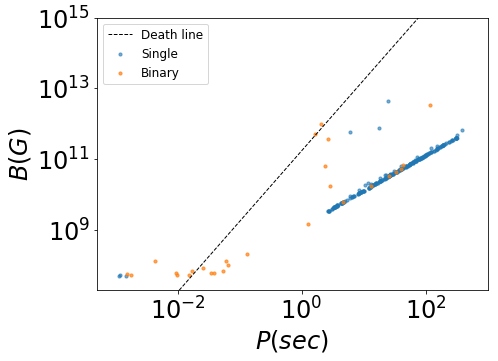

In [45]:
##Check the B-P plot
snaps_tc = dyn.get_snapshots(testpath+'initial')
lastsnap_tc = snaps_tc[-1]
B_s, B_b, P_s, P_b = ns.get_snap_BP(lastsnap_tc)

x=np.logspace(-4.0, 2.0, num=50)

plt.figure(figsize = (7, 5))
plt.plot(x, (x**2)*(0.17*10**12), 'k--', lw = 1, label = 'Death line')
plt.scatter(P_s, B_s, s=10, label = 'Single', alpha = 0.6)
plt.scatter(P_b, B_b, s=10, label = 'Binary', alpha = 0.7)

plt.xlim(0.5*10**-3, 1000.)
plt.ylim(2*10**7, 10**15)

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$P(sec)$')
plt.ylabel(r'$B(G)$')

plt.legend(loc='best', fontsize=12)

##What's the straightline that all the pulsars stop at?